# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Importing libraries

In [3]:
import pandas as pd
import numpy as np
import math
import json
from tqdm import tqdm, tqdm_notebook
% matplotlib inline

## Reading files

In [4]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## DEFINE: The customer journey

In [5]:
def customer_journey(customer_number, df = transcript):
    """
    Takes in the customer id and delivers a customer journey including all customer interactions
    Args: 
        customer_number (str): customer number in the file
        df (pandas dataframe): dataframe with all interactions
    Return:
        customer_offer_df (pandas dataframe): a dataframe with all interactions of a customer
    """
    # getting unique customer ids
    cutosmer_ids = transcript['person'].unique().tolist()
    # building a dataframe for all transactions connected to a user
    customer_df = transcript.loc[transcript['person'] == cutosmer_ids[customer_number]]
    # merging user dataframe with caractheristics of each offer 
    customer_offer_df = customer_df.merge(portfolio, how="left", left_on='value_string', right_on = 'id')
    # removing id
    customer_offer_df.drop(columns=['id'], inplace = True)
    # creating a new column for marking the time that offer ends    
    customer_offer_df["offer ends"] = np.nan        
    customer_offer_df['duration'] = customer_offer_df['duration'] * 24
    customer_offer_df["offer ends"] = customer_offer_df["time"] + customer_offer_df['duration']
    
    return (customer_offer_df)

## DEFINE: Row finder function

In [6]:
def find_rows(df, column, value):
    """
    A function to select all the rows in a dataframe column that match a value
    Args: 
        df (pandas dataframe): dataframe with all interactions
        column (str): column title    
        value (str or list): criteria value       
    Return:
        rows (pandas dataframe): a dataframe with values matching the criteria
    """
    # checking if function has received a signle value or a list of values    
    if type(value) == list:
    # retrieving lists   
        rows = df.loc[df[column].isin(value)]    
    else:
        rows = df.loc[df[column] == value]
        
    return rows

## DEFINE: Function for extracting user transaction profile

In [7]:
def profile_builder(list_of_offer_ids, transaction_dictionary, journey_profile_dict, pipeline_profile):
    """
    A function for extracting user transaction profile
    Args: 
        list_of_offer_ids (list): dataframe with all interactions
        column (str): column title    
        value (str or list): criteria value   
        journey_profile_dict (dict): a dictinary which accumulates journey profiles
        pipeline_profile (list): the list representing the profile of transactions
    Return:
        rows (pandas dataframe): a dataframe with values matching the criteria
    """
    for id in list_of_offer_ids:
        # check if there any associated transactions
        if id in transaction_dictionary.keys():
        # getting the number of transaction associated with id
            transaction_count = transaction_dictionary[id]
        else:
        # else return 0
            transaction_count = 0
        # adding transaction count to the pipeline profile
        updated_pipeline_profile = pipeline_profile + [transaction_count]
        journey_profile_dict[id] = updated_pipeline_profile
        
    return journey_profile_dict

## Define: Building a summary of the user offer behavior

In [138]:
def pipeline_builder(customer_id):
    """
    A function for building a summary of the user offer behavior
    Args: 
        customer_id (integer): the customer id for building summary
    Return:
        profile_df (pandas dataframe): a dataframe with summary
    """
    # getting the customer journey for each user
    cj = customer_journey(customer_id)
    # getting the customer id
    person_id = cj['person'].unique()[0]
    # getting the list of received, viewed and completed offers
    offers_received = find_rows(cj, 'event', 'offer received')['value_string'].tolist()
    offers_viewed = find_rows(cj, 'event', 'offer viewed')['value_string'].tolist()
    offers_completed = find_rows(cj, 'event', 'offer completed')['value_string'].tolist()
    
    # a dictionary for holding journey profiles
    journey_profile = {}
    
    # different piplines for each user
    
    # pipeline 1: only received, not viewed or completed
    r_not_v_not_c = [i for i in offers_received if (i not in offers_viewed and i not in offers_completed)] 
    # pipeline 2: received, viewed but not completed
    r_v_not_c = [i for i in offers_received if (i in offers_viewed and i not in offers_completed)]
    # pipeline 3: received, viewed and completed
    r_v_c = [i for i in offers_received if (i in offers_viewed and i in offers_completed)]
    # pipeline 4: not received or viewed but completed
    not_r_not_v_c = [i for i in offers_completed if i not in offers_received]
    # pipeline 5: received, viewed and not completed but some transactions    
    transaction_times = find_rows (customer_journey(customer_id), 'event', 'transaction')['time']
    
    # conversion of transaction times to a list
    transaction_times = transaction_times.values.tolist()
    
    # the following part adds the number of transaction to each customer profile
    r_v_not_c_some_t = {}
    r_v_not_c_no_t = {}

    # finding offers that have one or multiple transactions associated with them
    for transaction_time in transaction_times:
        connected_offers = cj.loc[(cj['time'] <= transaction_time) & 
                   (cj['offer ends'] >= transaction_time) &
                   (cj['event'] == "offer received")]
        if connected_offers.empty:
            continue
        else:
            offers = connected_offers['value_string'].values

        for offer in offers: 
            try:
                r_v_not_c_some_t[offer] += 1
            except:
                r_v_not_c_some_t[offer] = 1 

    # pipeline 6: received, viewed and not completed and no transactions    
    r_v_not_c_no_t = [i for i in r_v_not_c if i not in r_v_not_c_some_t.keys()]
    
    # pipeline 7: received, not viewed but completed
    r_not_v_c = [i for i in offers_completed if (i in offers_received and i not in offers_viewed)]
    
    
    # building all user profiles
    profile_builder(r_not_v_not_c, r_v_not_c_some_t, journey_profile, [1,0,0])
    profile_builder(r_v_not_c, r_v_not_c_some_t, journey_profile, [1,1,0])
    profile_builder(r_v_c, r_v_not_c_some_t, journey_profile, [1,1,1])
    profile_builder(not_r_not_v_c, r_v_not_c_some_t, journey_profile, [0,0,1])
    profile_builder(r_not_v_c, r_v_not_c_some_t, journey_profile, [1,0,1])

    column_names = ["received", "viewed", "completed", "num_transactions"]
    
    # building a dataframe from the journey profile
    profile_df = pd.DataFrame.from_dict(journey_profile, orient='index',
                       columns=column_names)
    
    # adding offer and customer id indexes
    profile_df['offer_id'] = profile_df.index    
    profile_df['cusotmer_id'] = person_id

    return profile_df

### Data Preparation

In [9]:
# slicing the value column to create two new columns (parameter and value_string)
transcript['parameter'] = transcript['value'].apply(lambda x: list(x.keys())[0])
transcript['value_string'] = transcript['value'].apply(lambda x: list(x.values())[0])
transcript['parameter'] = transcript['parameter'].str.replace('_', ' ')
transcript.drop(columns=['value'], inplace = True)

In [10]:
# Building transaction and offer pipeline for all customers
num_of_unique_customers = transcript['person'].unique().shape[0]

for key in tqdm_notebook(range(num_of_unique_customers)):
    try:
        customer_offers_df = pd.concat([customer_offers_df, pipeline_builder(key)])
    except:
        customer_offers_df = pipeline_builder(key)

HBox(children=(IntProgress(value=0, max=17000), HTML(value='')))

### Adding Customer profile and offer attributes

In [14]:
# mergining the profile dataset with portfolio and profile data to add offer and customer information
customer_offers_info_df = customer_offers_df.merge(portfolio, how="left", left_on='offer_id', right_on = 'id').drop(columns=['id'])
customer_offers_full_df = customer_offers_info_df.merge(profile, how="left", left_on='cusotmer_id', right_on = 'id').drop(columns=['id'])        

### Converting Values to numeric

In [15]:
customer_offers_full_df[['received', 'viewed', 'completed', 'num_transactions']] = customer_offers_full_df[['received', 'viewed', 'completed', 'num_transactions']].apply(pd.to_numeric) 

### Saving a pickle file (To save the time needed for re-running the pipeline builder)

In [16]:
# saving dataframe as a pickle file
customer_offers_full_df.to_pickle("customer_offers_demo_data.pkl")

# Exploratory Analysis

#### Loding the pickle file (Only needed if we the kernel has been shutdown)

In [106]:
# saving dataframe as a pickle file
customer_offers_full_df = pd.read_pickle("customer_offers_demo_data.pkl")

### Visualizing age

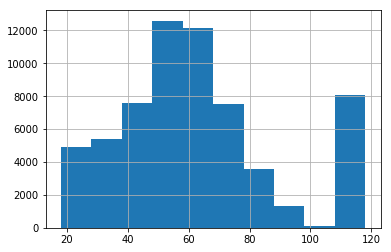

In [107]:
hist = customer_offers_full_df['age'].hist(bins=10)

### dropping age values over 99 years old

In [108]:
customer_offers_full_df = customer_offers_full_df.loc[customer_offers_full_df['age'] < 100]

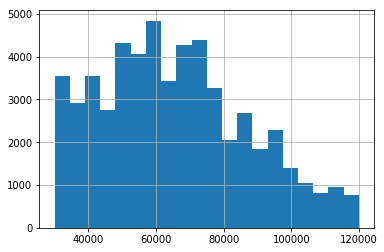

In [109]:
customer_offers_full_df['income'].hist(bins=20)

## Relationship between offers and rate of completion

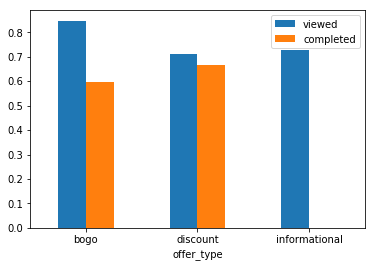

In [110]:
offer_type_stat = customer_offers_full_df.groupby(by = 'offer_type').mean()[['viewed', 'completed']]

ax = offer_type_stat.plot.bar(rot = 0)

## Relationship between gender and rate of completion

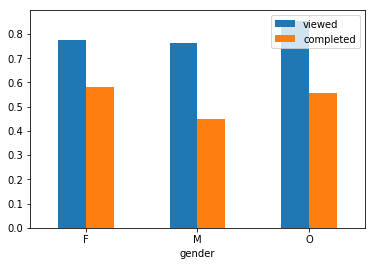

In [111]:
offer_type_stat = customer_offers_full_df.groupby(by = 'gender').mean()[['viewed', 'completed']]

ax = offer_type_stat.plot.bar(rot = 0)

### Creating bins for income and age to visualize relationships with the rate of completion

In [112]:
customer_offers_full_df['income_cut'] = pd.cut(customer_offers_full_df.income, bins=10) 
customer_offers_full_df['age_cut'] = pd.cut(customer_offers_full_df.age, bins=10) 

### Income levels and completed offers

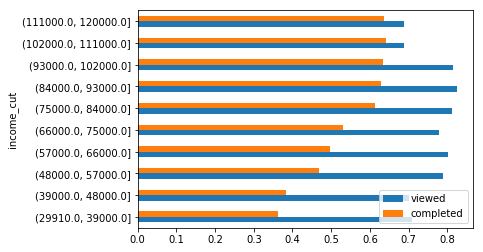

In [113]:
income_cut_stat = customer_offers_full_df.groupby(by = ['income_cut']).mean()[['viewed', 'completed']]

ax = income_cut_stat.plot.barh(rot=0)

### Age and completed discount offers


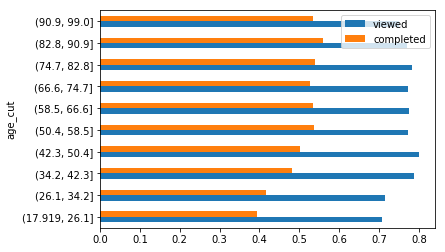

In [114]:
income_cut_stat = customer_offers_full_df.groupby(by = ['age_cut']).mean()[['viewed', 'completed']]

ax = income_cut_stat.plot.barh(rot=0)

## Data Preparation for Modelling

## Convert categorical variables to dummy variables

In [115]:
def dummy_maker(df, list_dummy_variables):
    """
    A function for creating dummay variables and adding them to a dataframe
    Args: 
        df (pandas dataframe): input dataframe
        list_dummy_variables (list): list of columns names to be turned into dummy variables
    Return:
        df (pandas dataframe): export dataframe with added dummy variables
    """    
    for variable in list_dummy_variables:
        
        just_dummies = pd.get_dummies(df[variable])

        df = pd.concat([df, just_dummies], axis=1)   
        
        df.drop([variable], inplace=True, axis=1)
        
    return df

### Converting channels to dummy variables

In [116]:
s = customer_offers_full_df['channels']

customer_offers_full_df[["email", "mobile", 'social', "web"]] = pd.get_dummies(s.apply(pd.Series).stack()).sum(level=0)

### Converting gender and offer type to dummy variables

In [117]:
customer_offers_full_df = dummy_maker(customer_offers_full_df, ['gender', 'offer_type'])

### Dropping last coulmn in each dummy variable

In [118]:
customer_offers_full_df.drop(columns = ['O', 'informational', 'web'], inplace= True)

In [119]:
customer_offers_full_df.drop(columns= ['cusotmer_id'], inplace = True)

#### Removing all rows with any null values

In [120]:
customer_offers_full_df.dropna(inplace = True)

#### Normalizing income and age

In [121]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

customer_offers_full_df[['income', 'age']] = min_max_scaler.fit_transform(customer_offers_full_df[['income', 'age']])

#### A new column which shows all offers that involved any transactions

In [122]:
customer_offers_full_df['any_transaction'] = customer_offers_full_df['num_transactions']

customer_offers_full_df.loc[customer_offers_full_df['any_transaction'] > 0, 'any_transaction'] = 1

### Saving a pickle file (To save the time needed for cleaning data)

In [123]:
# saving dataframe as a pickle file
customer_offers_full_df.to_pickle("customer_offer_df_ready_for_ml.pkl")

## Training and Testing Models

#### STEP 0 - Loding the pickle file (Only needed if we the kernel has been shutdown)

In [124]:
# reading dataframe as a pickle file
moddling_dataset = pd.read_pickle("customer_offer_df_ready_for_ml.pkl")

### STEP 1 - import libraries

In [126]:
# classifier modules
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC   
from sklearn.ensemble import GradientBoostingClassifier 

# Pipeline and GridSearch modules
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# evaluation and visualization modules
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

### STEP 2 - Split features and labels

In [127]:
labels = ['received', 'viewed', 'completed', 'num_transactions']

features = ['F', 'M', 'income', 'age', 'email', 'mobile', 'social', 'bogo', 'discount']

X = moddling_dataset[features]

Y = moddling_dataset['completed']

#### Convert features and label columns columns to numeric Values

In [128]:
X= X.astype(float)

Y = Y.apply(pd.to_numeric)

### STEP 3 - Define preprocessing and analysis steps

In [129]:
steps = {'random_forest': [('random_forest', RandomForestClassifier())],
        'svc': [('svc', SVC())],
        'gbr': [('gbr', GradientBoostingClassifier())]}

### STEP 4 - Define parameters for grid search

#### Random Forest

In [130]:
# Number of trees in random forest
n_estimators = [1, 10, 50, 100]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']

random_forest_parameters = {'random_forest__n_estimators': n_estimators, 
                            'random_forest__max_features': max_features}

#### SVC

In [131]:
kernel = ['linear', 'rbf', 'poly']
gammas = [1, 10]

svc_parameters = {'svc__kernel': kernel,
                 'svc__gamma': gammas}

#### Gradient Boost

In [142]:
n_estimators = [1, 10, 50, 100]
max_depth = [1, 2, 10, 20]
max_features = [4]
learning_rate = [1, .5, 0.25]

gbr_parameters = {'gbr__n_estimators': n_estimators, 
                  'gbr__max_depth': max_depth,
                 'gbr__max_features': max_features,
                 'gbr__learning_rate': learning_rate}

#### Create the grid of estimators

In [133]:
param_grid_parameters = {'random_forest': random_forest_parameters, 
                         'svc': svc_parameters,
                        'gbr': gbr_parameters}

### STEP 5 - Split data to training and test

In [134]:
X_train,X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 30)

### STEP 6 - Fit data into Grid, Find best parameters and Evaluation of results

In [135]:
def fit_evaluate_ML (estimator, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):  
    """
    A function for training the dataset, finding best parameters and showing the result of model
    Args: 
        estimator (string): type of estimator to be used for training the dataset. The estimator should be slected from the 
        dictionary param_grid_parameters. 
        X_train (pandas dataframe): features training dataset
        y_train (pandas dataframe): labels training dataset
        X_test (pandas dataframe): features test dataset
        y_test (pandas dataframe): labels test dataset
    Return:
        None
    """       
    
    pipeline = Pipeline(steps[estimator])

    model = GridSearchCV(pipeline, param_grid_parameters[estimator])
    
    # fitting the model
    model.fit(X_train, y_train)
    
    # predicting results in the test dataset
    Y_pred = model.predict(X_test)
    
    # creating cofusion matrix 
    cnf_matrix = metrics.confusion_matrix(y_test, Y_pred)

    # visualizing the confusion matrix
    %matplotlib inline
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    # printing metrics of confusion matrix
    print("Accuracy:", metrics.accuracy_score(y_test, Y_pred))
    print("Precision:",metrics.precision_score(y_test, Y_pred))
    print("Recall:",metrics.recall_score(y_test, Y_pred))
    print("F1:",metrics.f1_score(y_test, Y_pred))
    
    # printing best parameters
    print (model.best_params_)

### STEP 7 - Feed into pipeline and define grid

Accuracy: 0.745128251609
Precision: 0.704910714286
Recall: 0.851060007186
F1: 0.771121601823
{'gbr__learning_rate': 0.5, 'gbr__max_depth': 2, 'gbr__max_features': 4, 'gbr__n_estimators': 100}


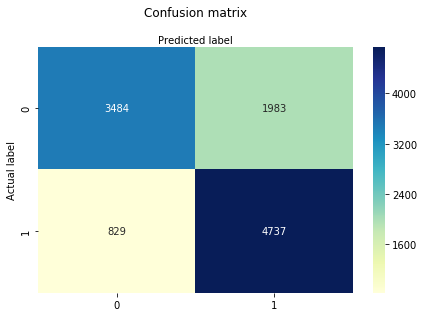

In [136]:
fit_evaluate_ML('gbr')

Accuracy: 0.745128251609
Precision: 0.703217237308
Recall: 0.856090549766
F1: 0.772160103711
{'svc__gamma': 10, 'svc__kernel': 'rbf'}


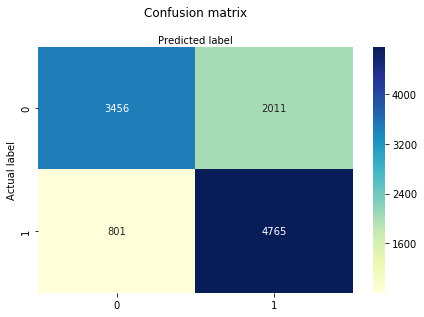

In [137]:
fit_evaluate_ML('svc')

Accuracy: 0.706698087556
Precision: 0.696990192763
Recall: 0.740567732663
F1: 0.718118466899
{'random_forest__max_features': 'auto', 'random_forest__n_estimators': 50}


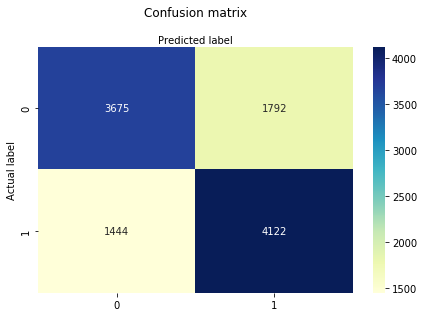

In [52]:
fit_evaluate_ML('random_forest')